# Вебинар 6. Двухуровневые модели рекомендаций


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from best_rec_lib.metrics import precision_at_k, recall_at_k, ap_k
from best_rec_lib.utils import prefilter_items
from best_rec_lib.recommenders import MainRecommender

In [4]:
data = pd.read_csv('../data/retail_train.csv')
item_features = pd.read_csv('../data/product.csv')
user_features = pd.read_csv('../data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [5]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [6]:
data_train_lvl_1["user_id"].unique()

array([2375, 1364, 1172, ...,  363, 1721, 1480])

In [7]:
data_train_lvl_1.shape

(861404, 13)

In [8]:
recommender = MainRecommender(data_train_lvl_1)

/home/nal/anaconda3/lib/python3.9/site-packages/implicit/utils.py:33: UserWarning: Intel MKL BLAS detected. Its highly recommend to set the environment variable 'export MKL_NUM_THREADS=1' to disable its internal multithreading
  warnings.warn(


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?

In [9]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [10]:
# your_code
result_lvl_1['recommended_20']=result_lvl_1['user_id'].map(lambda x: recommender.get_als_recommendations(x,N=20))

In [11]:
# your_code
result_lvl_1['recommended_50']=result_lvl_1['user_id'].map(lambda x: recommender.get_als_recommendations(x,N=50))

In [12]:
result_lvl_1['recommended_100']=result_lvl_1['user_id'].map(lambda x: recommender.get_als_recommendations(x,N=100))

In [13]:
result_lvl_1['recommended_200']=result_lvl_1['user_id'].map(lambda x: recommender.get_als_recommendations(x,N=200))

In [14]:
result_lvl_1['recommended_500']=result_lvl_1['user_id'].map(lambda x: recommender.get_als_recommendations(x,N=500))

In [16]:
result_lvl_1['own']=result_lvl_1['user_id'].map(lambda x: recommender.get_own_recommendations(x,N=500))

In [15]:
result_lvl_1['recommended_1500']=result_lvl_1['user_id'].map(lambda x: recommender.get_own_recommendations(x,N=1500))

In [17]:
result_lvl_1

,user_id,actual,recommended_20,recommended_50,recommended_100,recommended_200,recommended_500,recommended_1500,own
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[5569374, 940947, 878996, 1070820, 1029743, 88...","[5569374, 940947, 878996, 1070820, 1029743, 88...","[5569374, 940947, 878996, 1070820, 1029743, 88...","[5569374, 940947, 878996, 1070820, 1029743, 88...","[5569374, 940947, 878996, 1070820, 1029743, 88...","[1029743, 1106523, 5569230, 916122, 844179, 10...","[1029743, 1106523, 5569230, 916122, 844179, 10..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[5569230, 1029743, 8090521, 1106523, 8090537, ...","[5569230, 1029743, 8090521, 1106523, 8090537, ...","[5569230, 1029743, 8090521, 1106523, 8090537, ...","[5569230, 1029743, 8090521, 1106523, 8090537, ...","[5569230, 1029743, 8090521, 1106523, 8090537, ...","[1029743, 1106523, 5569230, 916122, 844179, 10...","[1029743, 1106523, 5569230, 916122, 844179, 10..."
2,4,"[883932, 970760, 1035676, 1055863, 1097610, 67...","[1029743, 1106523, 5569230, 1075368, 844179, 9...","[1029743, 1106523, 5569230, 1075368, 844179, 9...","[1029743, 1106523, 5569230, 1075368, 844179, 9...","[1029743, 1106523, 5569230, 1075368, 844179, 9...","[1029743, 1106523, 5569230, 1075368, 844179, 9...","[1029743, 1106523, 5569230, 916122, 844179, 10...","[1029743, 1106523, 5569230, 916122, 844179, 10..."
3,6,"[1024306, 1102949, 6548453, 835394, 940804, 96...","[986912, 878996, 965267, 1026118, 835098, 8966...","[986912, 878996, 965267, 1026118, 835098, 8966...","[986912, 878996, 965267, 1026118, 835098, 8966...","[986912, 878996, 965267, 1026118, 835098, 8966...","[986912, 878996, 965267, 1026118, 835098, 8966...","[1029743, 1106523, 5569230, 916122, 844179, 10...","[1029743, 1106523, 5569230, 916122, 844179, 10..."
4,7,"[836281, 843306, 845294, 914190, 920456, 93886...","[1029743, 916122, 1126899, 866211, 1122358, 83...","[1029743, 916122, 1126899, 866211, 1122358, 83...","[1029743, 916122, 1126899, 866211, 1122358, 83...","[1029743, 916122, 1126899, 866211, 1122358, 83...","[1029743, 916122, 1126899, 866211, 1122358, 83...","[1029743, 1106523, 5569230, 916122, 844179, 10...","[1029743, 1106523, 5569230, 916122, 844179, 10..."
...,...,...,...,...,...,...,...,...,...
2149,2496,"[831509, 867188, 1013623, 1048851, 5592734, 16...","[844179, 1044078, 916122, 874972, 899624, 1281...","[844179, 1044078, 916122, 874972, 899624, 1281...","[844179, 1044078, 916122, 874972, 899624, 1281...","[844179, 1044078, 916122, 874972, 899624, 1281...","[844179, 1044078, 916122, 874972, 899624, 1281...","[1029743, 1106523, 5569230, 916122, 844179, 10...","[1029743, 1106523, 5569230, 916122, 844179, 10..."
2150,2497,"[820291, 824759, 838797, 859010, 859075, 86077...","[5569230, 5569471, 5585510, 854852, 1106523, 1...","[5569230, 5569471, 5585510, 854852, 1106523, 1...","[5569230, 5569471, 5585510, 854852, 1106523, 1...","[5569230, 5569471, 5585510, 854852, 1106523, 1...","[5569230, 5569471, 5585510, 854852, 1106523, 1...","[1029743, 1106523, 5569230, 916122, 844179, 10...","[1029743, 1106523, 5569230, 916122, 844179, 10..."
2151,2498,"[865511, 962991, 1076374, 1102358, 5564901, 15...","[1029743, 1070820, 916122, 1126899, 844179, 86...","[1029743, 1070820, 916122, 1126899, 844179, 86...","[1029743, 1070820, 916122, 1126899, 844179, 86...","[1029743, 1070820, 916122, 1126899, 844179, 86...","[1029743, 1070820, 916122, 1126899, 844179, 86...","[1029743, 1106523, 5569230, 916122, 844179, 10...","[1029743, 1106523, 5569230, 916122, 844179, 10..."
2152,2499,"[861282, 921744, 1050968, 13842089, 828837, 86...","[1029743, 5569230, 8090521, 1106523, 1044078, ...","[1029743, 5569230, 8090521, 1106523, 1044078, ...","[1029743, 5569230, 8090521, 1106523, 1044078, ...","[1029743, 5569230, 8090521, 1106523, 1044078, ...","[1029743, 5569230, 8090521, 1106523, 1044078, ...","[1029743, 1106523, 5569230, 916122, 844179, 10...","[1029743, 1106523, 5569230, 916122, 844179, 10..."


In [18]:
result_lvl_1.apply(lambda row: recall_at_k(row['recommended_20'], row['actual'],k=20), axis=1).mean()

0.04035332939253407

In [19]:
result_lvl_1.apply(lambda row: recall_at_k(row['own'], row['actual'],k=20), axis=1).mean()

0.030309691454100375

In [20]:
result_lvl_1.apply(lambda row: recall_at_k(row['recommended_50'], row['actual'],k=50), axis=1).mean()

0.06360705523834641

In [21]:
result_lvl_1.apply(lambda row: recall_at_k(row['own'], row['actual'],k=50), axis=1).mean()

0.04320315380335991

In [22]:
result_lvl_1.apply(lambda row: recall_at_k(row['recommended_100'], row['actual'],k=100), axis=1).mean()

0.08669449486394494

In [23]:
result_lvl_1.apply(lambda row: recall_at_k(row['own'], row['actual'],k=100), axis=1).mean()

0.06156821408022

In [24]:
result_lvl_1.apply(lambda row: recall_at_k(row['recommended_200'], row['actual'],k=200), axis=1).mean()

0.1159406543443711

In [25]:
result_lvl_1.apply(lambda row: recall_at_k(row['own'], row['actual'],k=200), axis=1).mean()

0.08940276042445733

In [26]:
result_lvl_1.apply(lambda row: recall_at_k(row['recommended_500'], row['actual'],k=500), axis=1).mean()

0.1625204055394276

In [27]:
result_lvl_1.apply(lambda row: recall_at_k(row['recommended_1500'], row['actual'],k=1500), axis=1).mean()

0.20963998757785057

In [28]:
result_lvl_1.apply(lambda row: recall_at_k(row['own'], row['actual'],k=500), axis=1).mean()

0.1318168244194135

## Дают ли own recommendtions + top-popular лучший recall?
### - нет, от k = 50 до 500 лучше использовать ALS

In [29]:
#
num_k = ([20,50,100,200,500,1500])
values_recall = [0.04,0.061, 0.088,0.115,0.161,0.21]

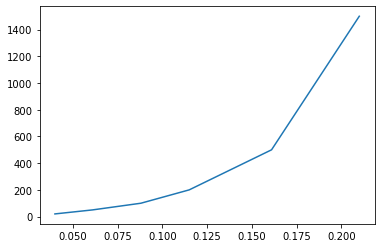

In [30]:
plt.plot(values_recall,num_k)
plt.show()

### Лучше брать число кандидатов до К = 500 т.к. график функции нелинейно зависит от K, и брать слишком большие значения не имеет смысла+для больших К нужно будет больше вычислительной мощности

### Задание 2.

Обучите модель 2-ого уровня, при этом:
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5, map@5, ndcg@5 при использовании двухуровневой модели?

In [31]:
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']

In [32]:
# Пока только warm start
train_users = data_train_lvl_1['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=200))

In [33]:
users_lvl_2.head(2)

,user_id,candidates
0,2070,"[899624, 1029743, 844179, 1044078, 965267, 983..."
1,2021,"[1029743, 1044078, 1106523, 844179, 5569230, 9..."


In [34]:
s = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'

In [35]:
s

0        899624
0       1029743
0        844179
0       1044078
0        965267
         ...   
2153    9527159
2153    1004945
2153     916990
2153    5591103
2153    1026118
Name: item_id, Length: 430200, dtype: int64

In [36]:
users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)
users_lvl_2['flag'] = 1

users_lvl_2.head(4)

,user_id,item_id,flag
0,2070,899624,1
0,2070,1029743,1
0,2070,844179,1
0,2070,1044078,1


In [37]:
users_lvl_2['user_id'].nunique()

2151

In [42]:
users_lvl_2.shape[0]

430200

In [132]:
targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1  # тут только покупки 

targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

targets_lvl_2['target'].fillna(0, inplace= True)
targets_lvl_2.drop('flag', axis=1, inplace=True)

In [139]:
targets_lvl_2['user_id']

0         2070
1         2070
2         2070
3         2070
4         2070
          ... 
436996    1745
436997    1745
436998    1745
436999    1745
437000    1745
Name: user_id, Length: 437001, dtype: int64

#test sparsity

In [44]:
targets_lvl_2['target'].mean()

0.05186029322587363

In [45]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [46]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [163]:
targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

targets_lvl_2.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,899624,1.0,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),10 LB,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,1029743,0.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


In [193]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2[['target']]

In [194]:
cat_feats = X_train.columns[2:].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc']

In [208]:
X_train.groupby('user_id').count().reset_index().X_train[user_id]

,user_id,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,1,211,211,211,211,211,211,211,211,211,211,211,211,211,211
1,2,200,200,200,200,200,200,200,0,0,0,0,0,0,0
2,4,201,201,201,201,201,201,201,0,0,0,0,0,0,0
3,6,206,206,206,206,206,206,206,0,0,0,0,0,0,0
4,7,201,201,201,201,201,201,201,201,201,201,201,201,201,201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2146,2496,206,206,206,206,206,206,206,206,206,206,206,206,206,206
2147,2497,202,202,202,202,202,202,202,202,202,202,202,202,202,202
2148,2498,202,202,202,202,202,202,202,202,202,202,202,202,202,202
2149,2499,204,204,204,204,204,204,204,204,204,204,204,204,204,204


In [190]:
X_train.join(chislo_pos_v_zakaze, on='user_id', how='inner',lsuffix='_left', rsuffix='_right')

,user_id,item_id_left,manufacturer_left,department_left,brand_left,commodity_desc_left,sub_commodity_desc_left,curr_size_of_product_left,age_desc_left,marital_status_code_left,...,commodity_desc_right,sub_commodity_desc_right,curr_size_of_product_right,age_desc_right,marital_status_code_right,income_desc_right,homeowner_desc_right,hh_comp_desc_right,household_size_desc_right,kid_category_desc_right
0,2070,899624,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),10 LB,45-54,U,...,200,200,200,200,200,200,200,200,200,200
1,2070,1029743,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,45-54,U,...,200,200,200,200,200,200,200,200,200,200
2,2070,844179,2852,MEAT,National,BEEF,PRIMAL,,45-54,U,...,200,200,200,200,200,200,200,200,200,200
3,2070,1044078,2845,MEAT,National,BEEF,LEAN,,45-54,U,...,200,200,200,200,200,200,200,200,200,200
4,2070,965267,2,PRODUCE,National,MELONS,WATERMELON SEEDLESS WHOLE,40 CT,45-54,U,...,200,200,200,200,200,200,200,200,200,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436996,1745,9527159,544,GROCERY,National,BAG SNACKS,MULT PK BAG SNACKS,24 OZ,45-54,A,...,200,200,200,200,200,200,200,200,200,200
436997,1745,1004945,794,GROCERY,National,COLD CEREAL,KIDS CEREAL,17.2 OZ,45-54,A,...,200,200,200,200,200,200,200,200,200,200
436998,1745,916990,103,GROCERY,National,SOFT DRINKS,SFT DRNK MLT-PK BTL CARB (EXCP,24 OZ,45-54,A,...,200,200,200,200,200,200,200,200,200,200
436999,1745,5591103,69,GROCERY,Private,COLD CEREAL,KIDS CEREAL,32 OZ,45-54,A,...,200,200,200,200,200,200,200,200,200,200


In [106]:
lgb = LGBMClassifier(objective='binary', max_depth=7, categorical_column=cat_feats, num_leaves=28)
lgb.fit(X_train, y_train)

train_preds = lgb.predict(X_train)

/home/nal/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/nal/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:863: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))
